In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from dataloader import train_dl, val_dl
from unet import UNet, ConvBlock
from loss_functions import DiceLoss, FocalTverskyLoss
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import time
import os
from tqdm import tqdm

AUGMENTATION:  True


In [2]:
shape = (144, 240, 240)

In [3]:
print('cuda available: ', torch.cuda.is_available())
device = torch.device("cuda:0")
print('device name: ', torch.cuda.get_device_name(device))
print('device info: ', torch.cuda.get_device_properties(device))
#torch.cuda.memory_summary()

cuda available:  True
device name:  NVIDIA GeForce RTX 3090
device info:  _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24259MB, multi_processor_count=82)


In [4]:
"""
model = UNet().to(device)

x = torch.zeros((1,1,144,240,240)).to('cuda')

base_dir = '/home/csanyid/BraTS'
data_dir = os.path.join(base_dir, 'data/train')
preprocessed_train_dir = os.path.join(base_dir, 'data/preprocessed_train')
preprocessed_val_dir = os.path.join(base_dir, 'data/preprocessed_val')
a = np.load(os.path.join(preprocessed_train_dir, '001.npy'))
a = torch.from_numpy(a).to('cuda', dtype = torch.float)


print('net output shape ', model(a[None, 0:4, ...]).shape)
"""

"\nmodel = UNet().to(device)\n\nx = torch.zeros((1,1,144,240,240)).to('cuda')\n\nbase_dir = '/home/csanyid/BraTS'\ndata_dir = os.path.join(base_dir, 'data/train')\npreprocessed_train_dir = os.path.join(base_dir, 'data/preprocessed_train')\npreprocessed_val_dir = os.path.join(base_dir, 'data/preprocessed_val')\na = np.load(os.path.join(preprocessed_train_dir, '001.npy'))\na = torch.from_numpy(a).to('cuda', dtype = torch.float)\n\n\nprint('net output shape ', model(a[None, 0:4, ...]).shape)\n"

In [5]:
#model = UNet().to(device)
model = torch.load('train_2/model.pth').to(device)
#loss_fn = DiceLoss()
loss_fn = FocalTverskyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
epochs = 2000

In [ ]:
#Train
def train(dataloader, model, loss_fn, optimizer):
    print('train')
    size = len(dataloader.dataset)
    losses = []
    model.train()
    for batch, (x, y) in tqdm(enumerate(dataloader)):
        #if batch % 10 == 0:
        #    print('batch: ', batch)
        x, y = x.to(device, torch.float32), y.to(device, torch.float32)
      
        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)
        losses.append(loss)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #if batch % 100 == 0:
        #    loss, current = loss.item(), batch * len(X)
        #    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    avg_loss = sum(losses)/len(losses)
    print('train loss: ', avg_loss)
    return float(avg_loss)

def val(dataloader, model, loss_fn):
    print('val')
    size = len(dataloader.dataset)
    losses = []
    model.eval()
    for batch, (x, y) in tqdm(enumerate(dataloader)):
        #if batch%10 == 0:
        #    print('val batch: ', batch)
        x, y = x.to(device, torch.float32), y.to(device, torch.float32)
              
        # Compute prediction error
        with torch.no_grad():
            pred = model(x)
            loss = loss_fn(pred, y)
        losses.append(loss)

        del x, y, pred
        torch.cuda.empty_cache()
        
        #if batch % 100 == 0:
        #    loss, current = loss.item(), batch * len(X)
        #    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    avg_loss = sum(losses)/len(losses)
    print('val loss: ', avg_loss)
    return float(avg_loss)

with open('train_2/train_val_losses.json', 'rb') as f:
    data = json.load(f)
    train_losses = data['train']
    val_losses = data['val']
best_val_loss = 1
start_time = time.ctime()
for t in range(783, epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dl, model, loss_fn, optimizer)
    train_losses.append(train_loss)
    val_loss = val(val_dl, model, loss_fn)
    val_losses.append(val_loss)
    
    torch.save(model, 'model.pth')
    model_info = {
        'epoch' : t,
        'train_loss' : train_loss,
        'val_loss' : val_loss,
        'time' : time.ctime()
    }
    with open('model_info.json', 'w') as f:
        json.dump(model_info, f)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model, 'model_best.pth')
        with open('model_best_info.json', 'w') as f:
            json.dump(model_info, f)
            
    plt.plot(train_losses, 'b', label='train')
    plt.plot(val_losses, 'r', label='val')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig('train_val_scores.jpg')
    plt.clf()
    
    finish_time = time.ctime()
    with open('train_val_losses.json', 'w') as f:
        json.dump({'train' : train_losses, 'val': val_losses, 'start_time' : start_time, 'finish_time' : finish_time},  f)
print("Done!")


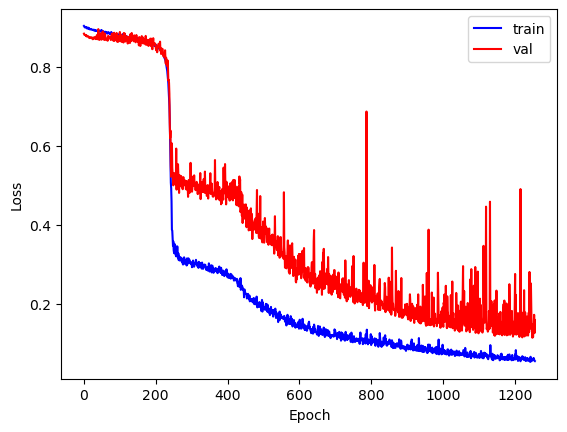

In [7]:
plt.plot(train_losses, 'b', label='train')
plt.plot(val_losses, 'r', label='val')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()